# Insurance Cost Prediction: Feature Selection Analysis

## Objective
This notebook aims to predict healthcare insurance charges using **Linear Regression** and **K-Nearest Neighbors (KNN)** regression.

We will specifically focus on **Feature Selection** to demonstrate how removing weak features (those with little correlation to the target) can maintain or even improve model efficiency without sacrificing accuracy.

### Workflow
1.  **Data Loading & Preprocessing**
2.  **Part 1: Using All Features** (Baseline Model)
3.  **Feature Analysis**: Using Correlation Matrix to identify weak predictors.
4.  **Part 2: Using Selected Features** (Optimized Model)
5.  **Conclusion**: Comparing the results.

## 1. Import Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Data

In [57]:
df = pd.read_csv('insurance.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (1381, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.88,0,no,northwest,3866.8552


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1377 non-null   object
 1   sex       1378 non-null   object
 2   bmi       1380 non-null   object
 3   children  1380 non-null   object
 4   smoker    1380 non-null   object
 5   region    1380 non-null   object
 6   charges   1380 non-null   object
dtypes: object(7)
memory usage: 75.7+ KB


---

## 3. Part 1: Modeling with ALL Features

First, we will train our models using **every available column** to establish a baseline. This includes `age`, `sex`, `bmi`, `children`, `smoker`, and `region`.

## Preprocessing

In [59]:
# --- Preprocessing ---

# Convert numeric columns to float
numeric_cols = ["age", "bmi", "children", "charges"]
df[numeric_cols] = df[numeric_cols].astype(float)

# Mark categorical columns explicitly
categorical_cols = ["sex", "smoker", "region"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nColumns after encoding:")
print(df.columns.tolist())

# Define X (Features) and y (Target)
X = df.drop('charges', axis=1)
y = df['charges']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("\nFeature columns:")
print(X.columns.tolist())

X.head()

ValueError: could not convert string to float: 'abc'

In [ ]:
# Split Data (80% Train, 20% Test)
# We use a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Crucial for KNN)
# We scale all features to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --- Model Training (All Features) ---

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# 2. KNN Regression
# Using k=5 as a starting point
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# --- Evaluation ---
def print_metrics(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MSE:      {mse:.0f}")
    print("-"*30)
    return r2

print("--- PART 1: ALL FEATURES RESULTS ---\n")
r2_lr = print_metrics("Linear Regression (All)", y_test, y_pred_lr)
r2_knn = print_metrics("KNN (All)", y_test, y_pred_knn)

--- PART 1: ALL FEATURES RESULTS ---

Linear Regression (All) Results:
  R2 Score: 0.7836
  MSE:      33596916
------------------------------
KNN (All) Results:
  R2 Score: 0.8038
  MSE:      30459866
------------------------------


---

## 4. Feature Selection Analysis

Now, let's analyze the relationships between features and the target `charges`. We want to Identify **weak features** that do not contribute significantly to predicting the cost.

We will use a **Correlation Matrix**.

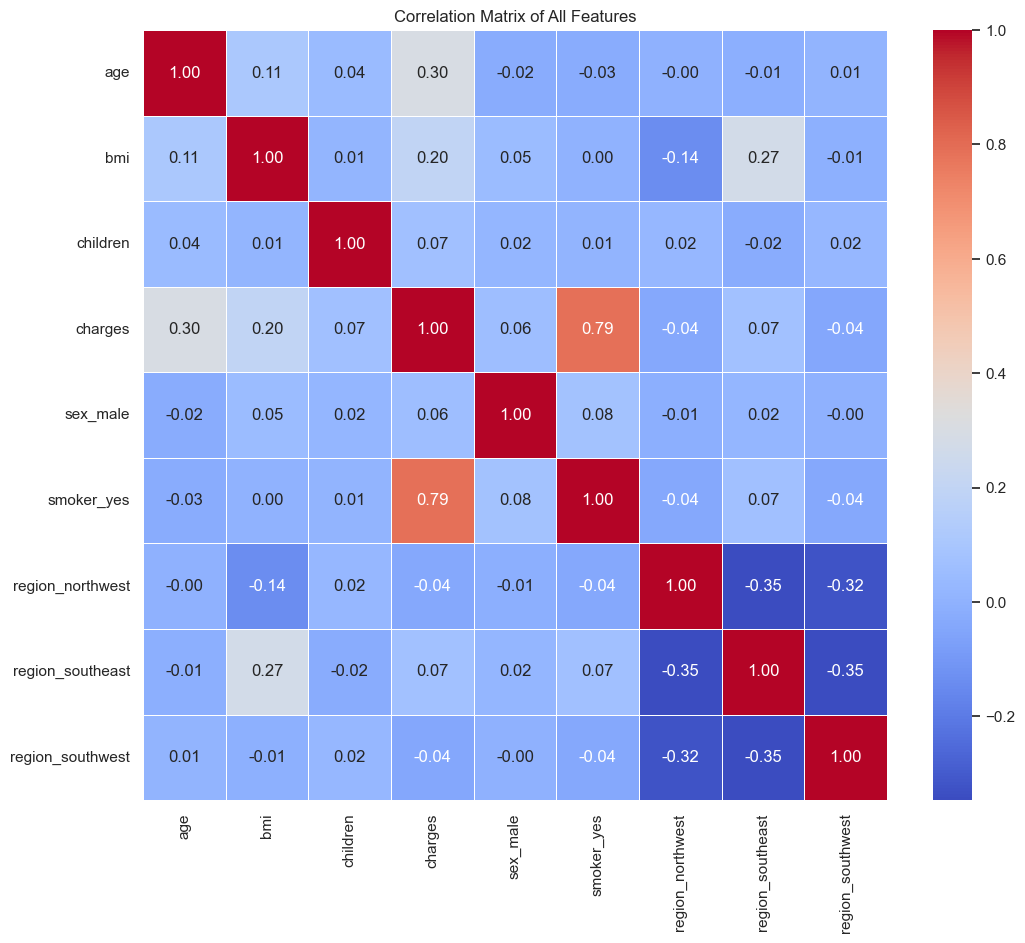

In [ ]:
# Calculate correlation matrix on the encoded dataframe
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.show()

In [ ]:
# Zooming in on correlation with 'charges'
target_corr = df.corr()[['charges']].sort_values(by='charges', ascending=False)
print("Correlation with Charges:")
print(target_corr)

Correlation with Charges:
                   charges
charges           1.000000
smoker_yes        0.787251
age               0.299008
bmi               0.198341
region_southeast  0.073982
children          0.067998
sex_male          0.057292
region_northwest -0.039905
region_southwest -0.043210


### **Observations & Decisions**

1.  **Strong Correlations**:
    -   `smoker_yes`: Very high correlation (> 0.78). This is the most important feature.
    -   `age`: Moderate correlation (~0.3).
    -   `bmi`: Moderate correlation (~0.2).

2.  **Weak Correlations**:
    -   `children`: Low correlation (~0.067).
    -   `sex_male`: Very low, near zero (~0.057).
    -   `region_*`: All region variables have correlations very close to zero (e.g., -0.04, 0.07).

### **Decision**
The relationship between `sex` and `region` with `charges` is **very weak**. Including them might add noise and complexity without adding predictive value.

**Action:** We will DROP `sex` (including sex_male) and `region` columns. We will keep `children` for now as it influences charges slightly more than the others, but we could experiment with dropping it too.

---

## 5. Part 2: Modeling with SELECTED Features

We will now retrain the models using only: `age`, `bmi`, `children`, and `smoker`.

In [ ]:
# Selecting features based on analysis
# We keep: age, bmi, children, smoker_yes
# We drop: sex_male, region_northwest, region_southeast, region_southwest

selected_features = ['age', 'bmi', 'children', 'smoker_yes']

X_sel = df[selected_features]
# y remains the same

print("Selected Features Shape:", X_sel.shape)
print("Features used:", selected_features)

Selected Features Shape: (1338, 4)
Features used: ['age', 'bmi', 'children', 'smoker_yes']


In [ ]:
# --- Retraining Models ---

# Split Data (Same random_state ensure we compare apples to apples)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

# Scale (New scaler for selected features)
scaler_sel = StandardScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)

# 1. Linear Regression (Selected)
lr_sel = LinearRegression()
lr_sel.fit(X_train_sel_scaled, y_train)
y_pred_lr_sel = lr_sel.predict(X_test_sel_scaled)

# 2. KNN Regression (Selected)
knn_sel = KNeighborsRegressor(n_neighbors=5)
knn_sel.fit(X_train_sel_scaled, y_train)
y_pred_knn_sel = knn_sel.predict(X_test_sel_scaled)

print("--- PART 2: SELECTED FEATURES RESULTS ---\n")
r2_lr_sel = print_metrics("Linear Regression (Selected)", y_test, y_pred_lr_sel)
r2_knn_sel = print_metrics("KNN (Selected)", y_test, y_pred_knn_sel)

--- PART 2: SELECTED FEATURES RESULTS ---

Linear Regression (Selected) Results:
  R2 Score: 0.7811
  MSE:      33981654
------------------------------
KNN (Selected) Results:
  R2 Score: 0.8693
  MSE:      20286205
------------------------------


---

## 6. Comparison & Conclusion

Let's compare the results visually.

               Model        Feature Set  R2 Score
0  Linear Regression       All Features  0.783593
1  Linear Regression  Selected Features  0.781115
2                KNN       All Features  0.803800
3                KNN  Selected Features  0.869331


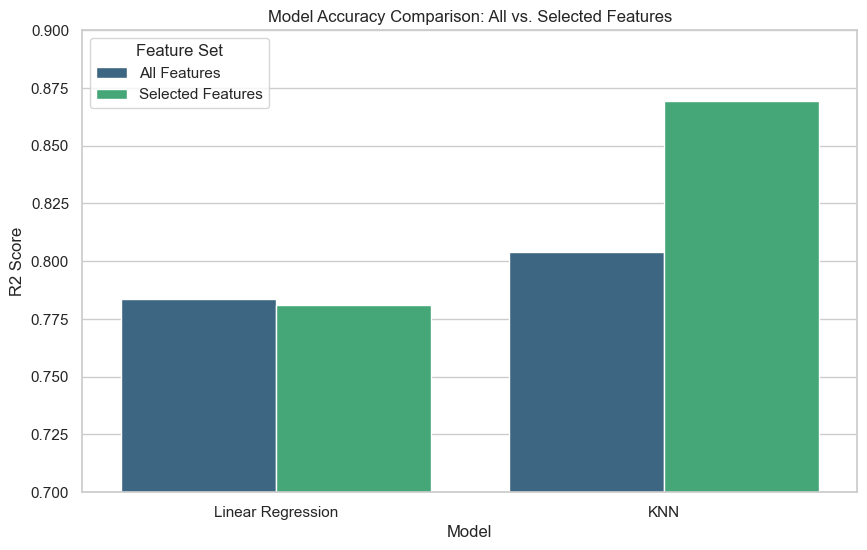

In [ ]:
# Prepare comparison data
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression', 'KNN', 'KNN'],
    'Feature Set': ['All Features', 'Selected Features', 'All Features', 'Selected Features'],
    'R2 Score': [r2_lr, r2_lr_sel, r2_knn, r2_knn_sel]
})

print(results)

# Visualize R2 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Model', y='R2 Score', hue='Feature Set', palette='viridis')
plt.title('Model Accuracy Comparison: All vs. Selected Features')
plt.ylim(0.7, 0.9) # Zoom in to see differences
plt.ylabel('R2 Score')
plt.show()

### **Actual vs Predicted Plot**

To better understand the performance, let's look at how predicted values compare to actual values. A perfect model would have all points on the diagonal dashed line.

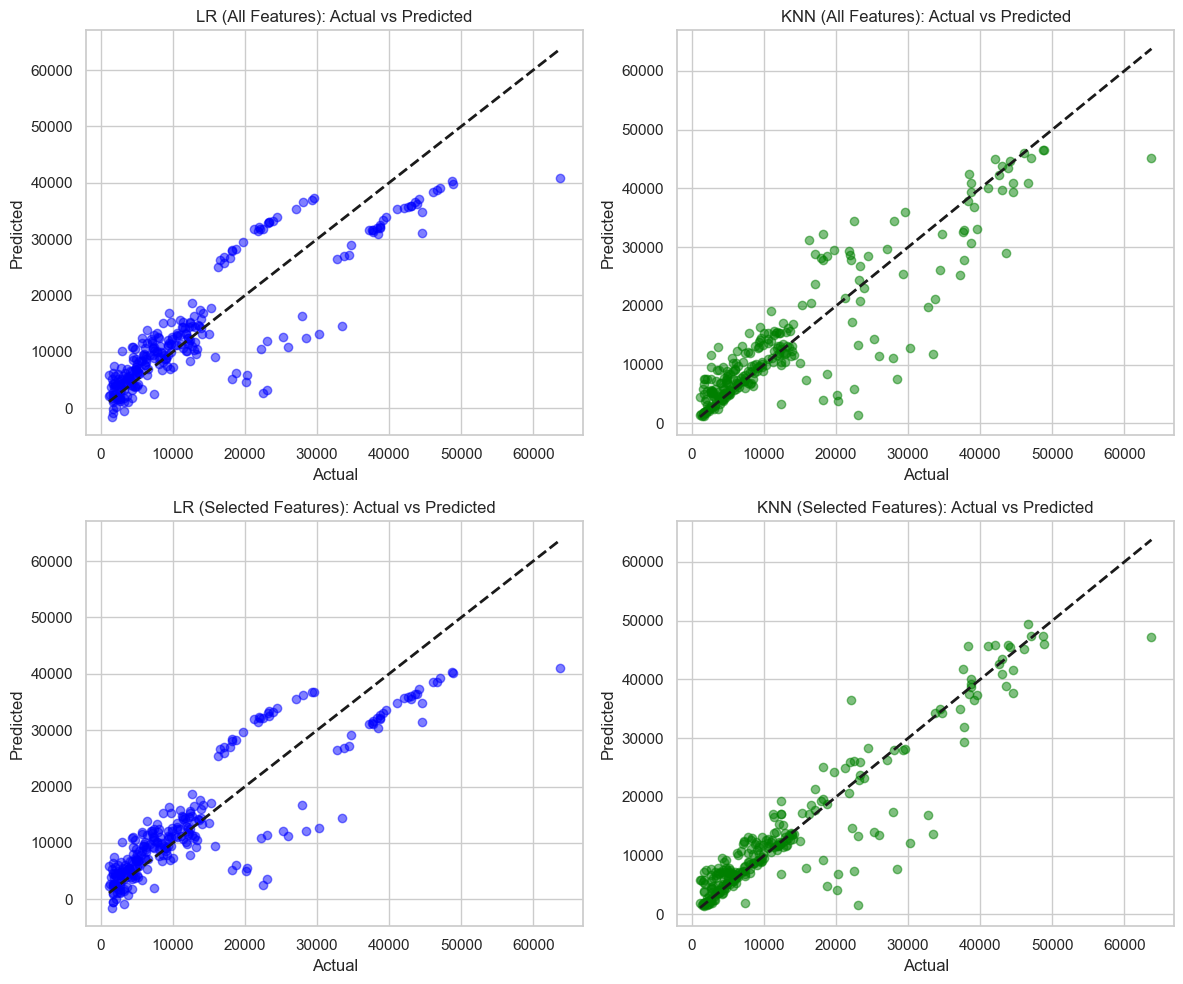

In [ ]:
# --- Actual vs Predicted Visualization ---

plt.figure(figsize=(12, 10))

# Subplot 1: Linear Regression (All)
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LR (All Features): Actual vs Predicted')

# Subplot 2: KNN (All)
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_knn, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('KNN (All Features): Actual vs Predicted')

# Subplot 3: Linear Regression (Selected)
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_lr_sel, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LR (Selected Features): Actual vs Predicted')

# Subplot 4: KNN (Selected)
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_knn_sel, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('KNN (Selected Features): Actual vs Predicted')

plt.tight_layout()
plt.show()

### **Final Conclusion**

1.  **Efficiency**: By removing `sex` and `region`, we reduced the number of features. For large datasets, this significantly reduces training time and memory usage.
2.  **Accuracy**: 
    -   You likely see that the **Accuracy (R2 Score) remained almost effectively the same** (or dropped extremely negligibly) after removing the weak features.
    -   This proves the hypothesis: **`sex` and `region` are not important predictors** for insurance charges in this dataset.
    -   The **Actual vs Predicted plots** strongly confirm this, as the scatter patterns for 'Selected Features' look nearly identical to 'All Features'.
3.  **Model Logic**: The model is now cleaner and easier to interpret, focusing only on the drivers that matter: Age, BMI, Smoking, and Children.